In [7]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import gc

import sys
sys.path.append("../src")
import FE
import dataset
import models
import util
from config import read_config, update_config
import train_helper
import infer_helper
import loss
import lrfinder
import optim
from metric import cal_mae_metric

In [10]:
config = read_config("LSTM4_base_epoch300_ROP")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/LSTM4_base_epoch300_ROP/


In [13]:
train, test = dataset.read_data(config)

In [19]:
train["pred"] = 0
for fold in range(5):
    train.loc[train.query(f"fold=={fold}").index, "pred"] = torch.load(f'{config.model_output_folder}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()

In [21]:
train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"], df['pred'], 1 - df["u_out"]))

fold
0    0.212459
1    0.184655
2    0.191463
3    0.192695
4    0.185847
dtype: float64

In [22]:
train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"], df['pred'], 1 - df["u_out"])).mean()

0.19342411717299024

In [24]:
ids = train.query("fold==1").breath_id.unique()

In [66]:
def plot_error(train, ax, breath_id):
    breath = train.query(f"breath_id == {breath_id}").copy()
    R, C = breath.iloc[0][["R","C"]]
    breath = breath.loc[:breath["u_out"].idxmax()-1,]
    ax.plot(breath["time_step"],breath["pressure"],label="y_true")
    ax.plot(breath["time_step"],breath["pred"],label="y_pred")
    ax.plot(breath["time_step"],breath["u_in"],label="u_in")
    diff = breath["pressure"] - breath["pred"]
    ax2 = ax.twinx()
    ax2.plot(breath["time_step"], diff, label='diff', color="red")
    ax2.axhline(y=0.19, color="red", linestyle="--", alpha=.3)
    ax2.axhline(y=0, color="red", linestyle="--", alpha=.3)
    ax2.axhline(y=-0.19, color="red", linestyle="--", alpha=.3)
    ax.legend(loc="lower right")
    ax2.legend(loc="upper right")
    ax.set_title(f"id: {breath_id}, R:{R}, C:{C}")
    ax.grid(axis='x')

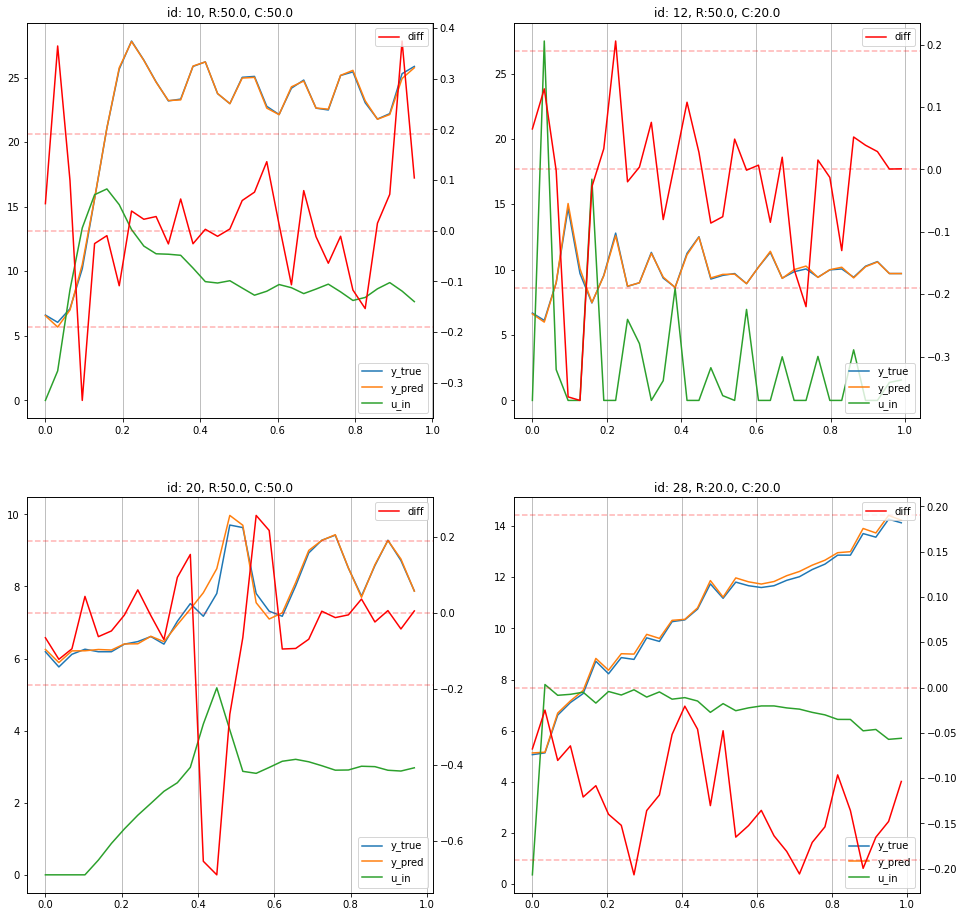

In [67]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[:4]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

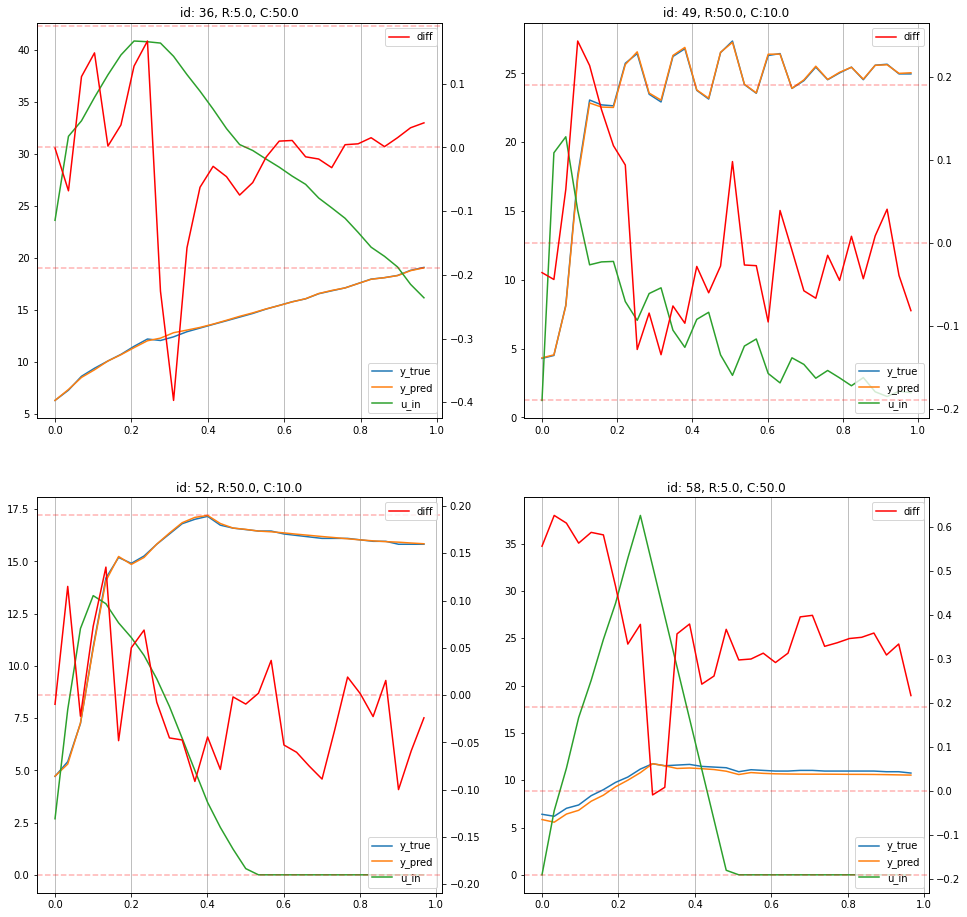

In [68]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[4:8]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

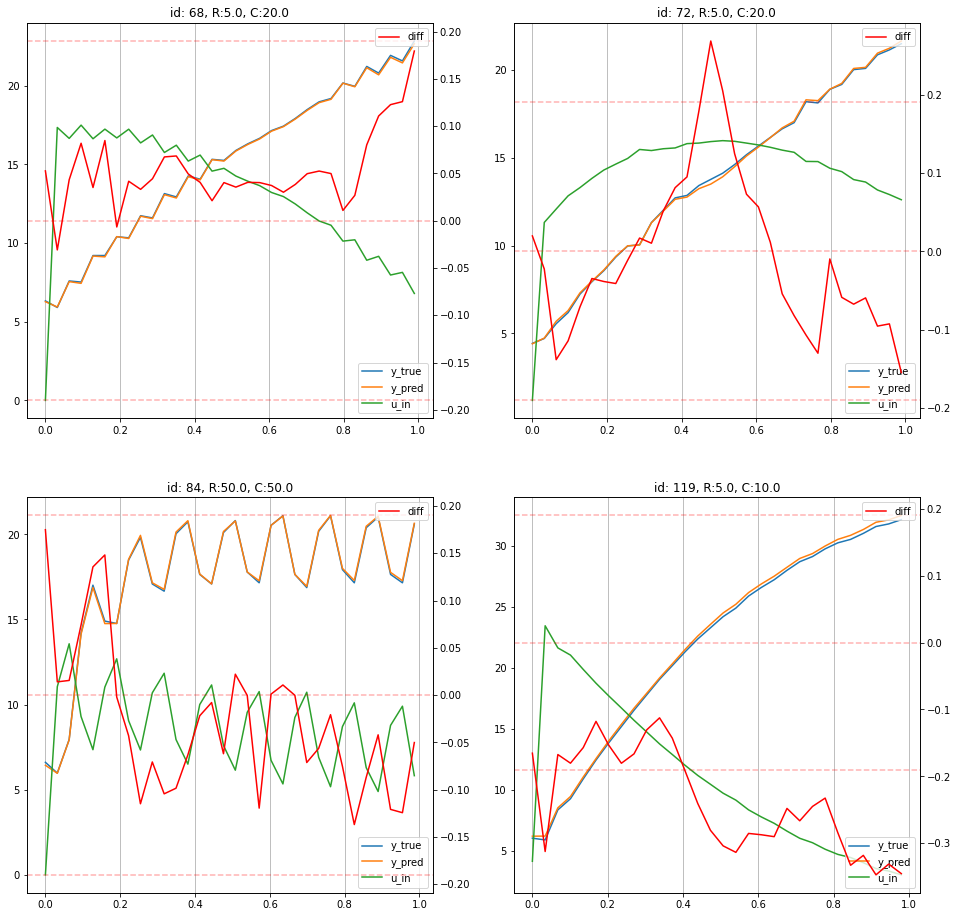

In [69]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
for i, breath_id in enumerate(ids[8:12]):
    plot_error(train, axes.flat[i], breath_id)
plt.show()

In [71]:
train["diff"] = train["pressure"] - train["pred"]

In [72]:
train["diff"].describe()

count    6.036000e+06
mean     3.258074e-03
std      3.339264e-01
min     -2.896518e+01
25%     -9.467893e-02
50%      5.311456e-07
75%      1.042494e-01
max      4.380577e+01
Name: diff, dtype: float64

In [74]:
train.loc[train["diff"].idxmax()]["breath_id"]

id           3.588083e+06
breath_id    7.476600e+04
R            5.000000e+01
C            1.000000e+01
time_step    2.485235e-01
u_in         0.000000e+00
u_out        0.000000e+00
pressure     6.482099e+01
fold         1.000000e+00
pred         2.101522e+01
diff         4.380577e+01
Name: 3588082, dtype: float64

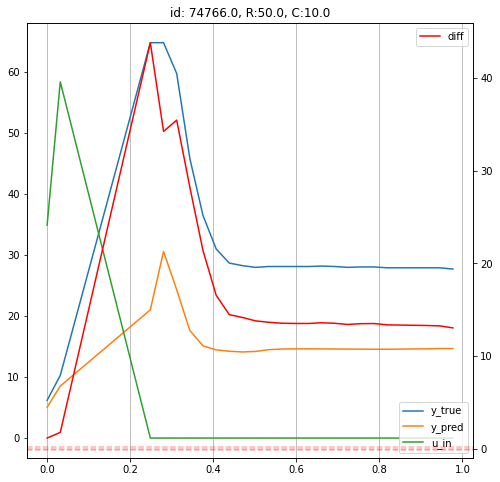

In [76]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_error(train, ax, train.loc[train["diff"].idxmax()]["breath_id"])
plt.show()

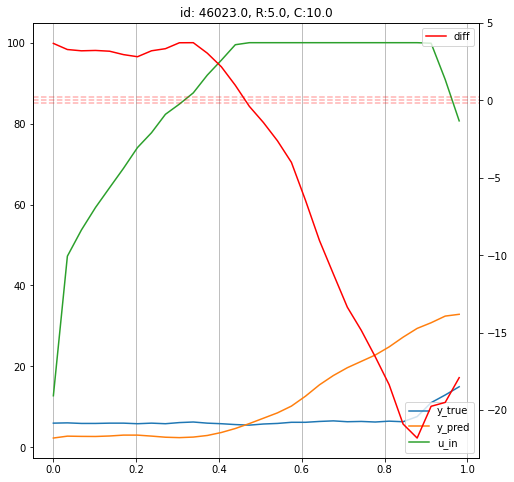

In [81]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_error(train, ax, train.loc[2213425]["breath_id"])
plt.show()

In [83]:
train.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'fold', 'pred', 'diff'],
      dtype='object')

In [90]:
train["abs_diff"] = train["diff"].abs() * (1-train["u_out"])
MAE_mean = train.query("u_out==0").groupby("breath_id")['abs_diff'].mean()

In [104]:
len(train["breath_id"].unique())

75450

In [105]:
len(MAE_mean)

75450

In [93]:
MAE_mean[MAE_mean>10]

breath_id
188      11.859971
74766    16.388279
Name: abs_diff, dtype: float64

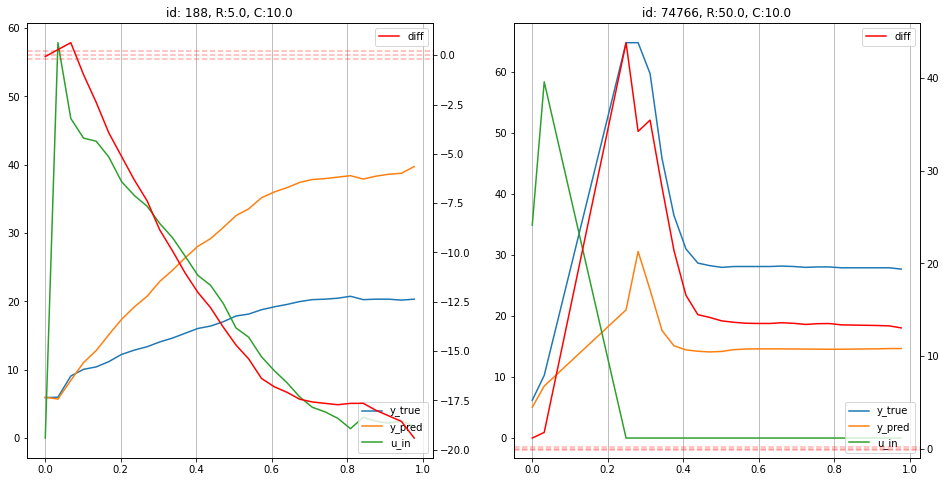

In [97]:
idxs = MAE_mean[MAE_mean>10].index
fig, axes = plt.subplots(1,len(idxs),figsize=(8*len(idxs),8))
for i, idx in enumerate(idxs):
    plot_error(train, axes[i], idx)
plt.show()

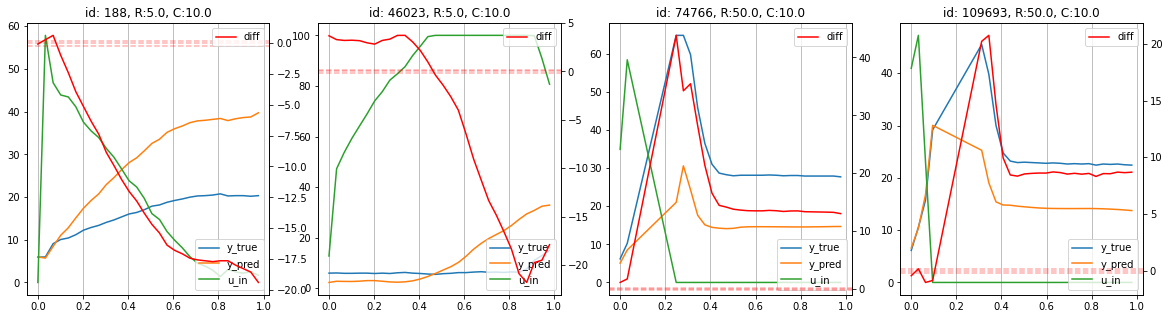

In [99]:
idxs = MAE_mean[MAE_mean>5].index
fig, axes = plt.subplots(1,len(idxs),figsize=(5*len(idxs),5))
for i, idx in enumerate(idxs):
    plot_error(train, axes[i], idx)
plt.show()

In [102]:
from tqdm import tqdm
from collections import defaultdict
RC_MAE_dict = defaultdict(list)
R_match = train.groupby("breath_id")["R"].first()
C_match = train.groupby("breath_id")["C"].first()
for idx in tqdm(MAE_mean.index):
    R,C = R_match.loc[idx], C_match.loc[idx]
    RC_MAE_dict[f"R{R}_C{C}"].append(MAE_mean.loc[idx])

100%|███████████████████████████████████████████████████████████| 75450/75450 [00:01<00:00, 53417.00it/s]


In [106]:
for key, maes in RC_MAE_dict.items():
    print(f"key: {key}, mean {np.mean(maes):.4f}, std {np.std(maes):.4f}, max {np.max(maes):.4f}")

key: R20_C50, mean 0.1737, std 0.1720, max 2.3999
key: R20_C20, mean 0.1809, std 0.2006, max 3.8632
key: R50_C20, mean 0.2711, std 0.3670, max 4.3211
key: R50_C50, mean 0.2934, std 0.4244, max 4.1960
key: R5_C50, mean 0.1258, std 0.1214, max 1.9453
key: R5_C20, mean 0.1254, std 0.1634, max 3.3888
key: R50_C10, mean 0.1834, std 0.3677, max 16.3883
key: R20_C10, mean 0.1839, std 0.2622, max 3.4216
key: R5_C10, mean 0.1917, std 0.3542, max 11.8600


In [113]:
len(MAE_mean[MAE_mean>4.3].index)

13

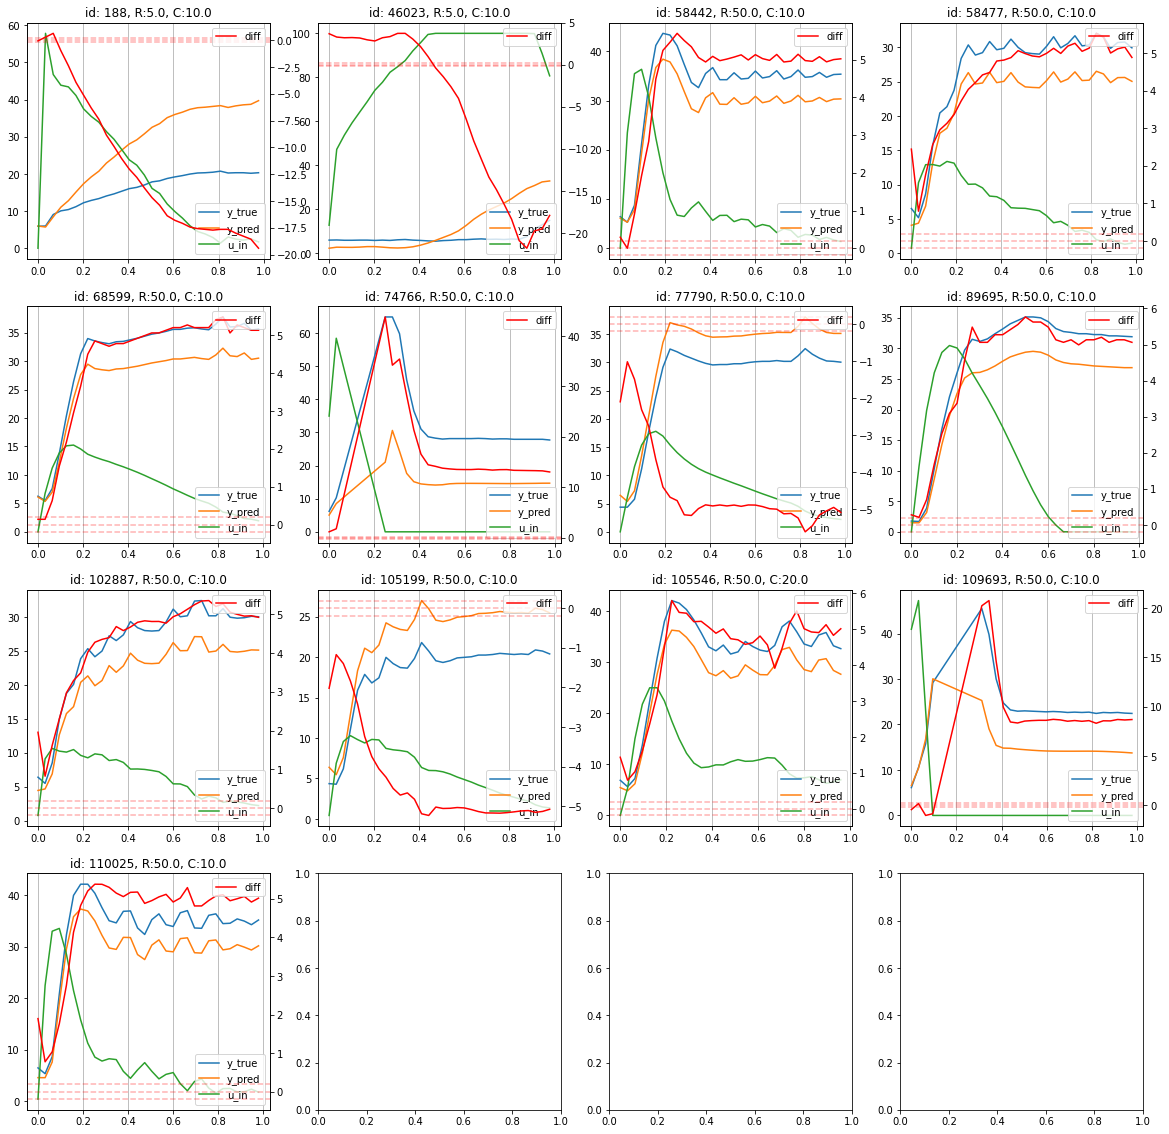

In [116]:
idxs = MAE_mean[MAE_mean>4.3].index
fig, axes = plt.subplots(4,len(idxs)//4+1,figsize=(20,20))
for i, idx in enumerate(idxs):
    plot_error(train, axes.flat[i], idx)
plt.show()

In [117]:
train.dtypes

[autoreload of models failed: Traceback (most recent call last):
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/vincent/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/v

id            uint32
breath_id     uint32
R             uint32
C             uint32
time_step    float32
u_in         float32
u_out           int8
pressure     float64
fold           int64
pred         float64
diff         float64
abs_diff     float64
dtype: object

In [118]:
train.R.unique()

array([20, 50,  5], dtype=uint32)

In [119]:
train.C.unique()


array([50, 20, 10], dtype=uint32)

In [120]:
train.u_out.unique()

array([0, 1], dtype=int8)

In [122]:
train.shape

(6036000, 12)

In [132]:
train.groupby("fold").size()

fold
0    1194800
1    1226240
2    1201520
3    1202720
4    1210720
dtype: int64

In [133]:
train['u_in']

0           0.083334
1          18.383041
2          22.509277
3          22.808823
4          25.355850
             ...    
6035995     1.489714
6035996     1.488497
6035997     1.558978
6035998     1.272663
6035999     1.482739
Name: u_in, Length: 6036000, dtype: float32